## Are there any filtered peptides that are forward & reverse?

In [13]:
import os
dtaselect_path = "/mongoa/DTASelect/10_2014_mass_spec/102214_HEK293_HCD35/indexDB_search_noProtDB_30ppm_50ppmfrag/DTASelect_p2_pfp/DTASelect-filter.txt"
dtaselect_path = "/mongoc/gstupp/DTASelect/unenriched/september15/121514_SC_sampleH1sol_25ug_HCD_FTMS_MS2/DTASelect-filter.txt"
from glob import glob
from metaproteomics.file_processing import blazmass_tools
from tqdm import tqdm
from pymongo import MongoClient
from itertools import chain
import matplotlib.pyplot as plt
client = MongoClient('localhost', 27018)
ProtDB = client['ProtDB_072114']['ProtDB_072114']
SeqDB = client['SeqDB_072114']['SeqDB_072114']

In [68]:
# Get all peptides
dta_parser = blazmass_tools.dta_select_parser(dtaselect_path)
peptides = blazmass_tools.get_unmod_peptides(dta_parser)

## Histogram of filtered peptide length

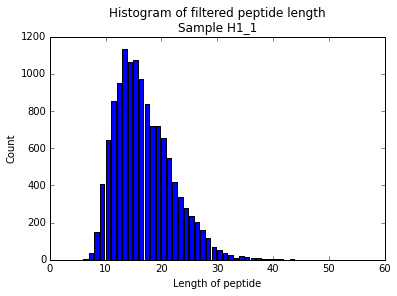

In [58]:
%matplotlib inline
from collections import Counter
x,y = zip(*Counter([len(x) for x in peptides]).items())
plt.bar(x,y)
plt.xlabel("Length of peptide")
plt.ylabel("Count")
plt.title("Histogram of filtered peptide length\nSample H1_1")
plt.show()

In [30]:
seq_results = list(SeqDB.find({'_id':{'$in':list(peptides)}}))
pep_parents = {result['_id']:[x['i'] for x in result['p']] for result in seq_results}
all_parents = set(chain(*[[x['i'] for x in result['p']] for result in seq_results]))
prot_rev = {x['_id']:x['d'].startswith("Reverse_") for x in ProtDB.find({'_id':{'$in':list(all_parents)}}, {'d':True})}

# these are peptides that have both forward and reverse parents/proteins
fr_peptides = set()
for result in seq_results:
    peptide = result['_id']
    parents = [x['i'] for x in result['p']]
    rev = [prot_rev[p] for p in parents]
    if len(set(rev)) > 1:
        fr_peptides.add(peptide)

In [62]:
print("{} peptides. {} forward/reverse peptides".format(len(peptides), len(fr_peptides)))

12767 peptides. 24 forward/reverse peptides


### How many loci contain any of these peptides?

In [65]:
dta_parser = list(blazmass_tools.dta_select_parser(dtaselect_path, small=True))
lc = 0
for locus in dta_parser:
    peptides = locus['unmod_peptide_seq']
    if any(p in fr_peptides for p in peptides):
        lc +=1
print("{} proteins. {} forward/reverse peptide containing proteins".format(len(dta_parser), lc))

8577 proteins. 156 forward/reverse peptide containing proteins


### are there any loci that were marked as reverse and contain peptides that could be both for or reverse?

In [41]:
dta_parser = blazmass_tools.dta_select_parser(dtaselect_path)
for locus in dta_parser:
    peptides = locus['unmod_peptide_seq']
    for_rev = [p for p in peptides if p in fr_peptides]
    if for_rev and any([prot_rev[x] for x in locus['all_loci']]):
        print(locus['all_loci'])
        print(for_rev)
        print(locus['unmod_peptide_seq'])

[119981761, 145754787, 145735335]
['KVEEYAR']
['QGKYVLEGEK', 'KVEEYAR']


### are there any loci that contain 2 peptides only where one is a peptide that could be both for or reverse?

In [46]:
dta_parser = blazmass_tools.dta_select_parser(dtaselect_path)
for locus in dta_parser:
    peptides = locus['unmod_peptide_seq']
    for_rev = [p for p in peptides if p in fr_peptides]
    if for_rev and len(peptides) == 2:
        print(locus['reverse'])
        print(locus['unmod_peptide_seq'])

True
['QGKYVLEGEK', 'KVEEYAR']
False
['DAIHWEINHEPITFTGEDQEILQR', 'NGVLFPR']
False
['FDFRDPK', 'VADLTVTVQPGEYR']
False
['FDFRDPK', 'FAQDDKHYTALR']
False
['VILSGIHEYYEPEELVGK', 'RTFEVR']
False
['YGVEHFR', 'YLSEFGFQAFPSVK']
False
['SVIVVGPELK', 'RLDVVESFR']
False
['AFGPGLEPTGCIVDKPAEFTIDAR', 'VKEVADFK']


### How many peptides with missed cleavages do we see?

(0, 1, 2, 3) (7722, 4234, 736, 75)


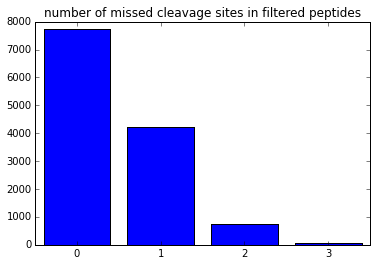

In [80]:
dta_parser = blazmass_tools.dta_select_parser(dtaselect_path)
peptides = blazmass_tools.get_unmod_peptides(dta_parser)
ms = [p.count("K")+p.count("R")-1 for p in peptides]
x,y = zip(*Counter(ms).items())
plt.bar([t-0.4 for t in x],y)
print(x,y)
plt.xticks([0,1,2,3])
plt.title("number of missed cleavage sites in filtered peptides")

In [82]:
ms3 = [p for p in peptides if p.count("K")+p.count("R")-1 == 3]
ms3

['RDWDYINEVAPPDAKGKR',
 'DKYIVMDENSKDTVWWTSDEYKNDNHPATQEAWNAVK',
 'VEIWWMNAVENEDKSTAPATTFIDKVEFFDKDGK',
 'QVHIMDVKDVDIGLKNEIASLAHEKK',
 'TLKDFGINEDEFKEKVDK',
 'GVKNDVDLTADDLKELVGTFKK',
 'AIEEVGDKLDANDKTAVEADLAALKDLIAK',
 'EAREEGFDDIAEKFEGVGAIEKEHEAR',
 'VQKENTVIVDGAGDKDKIQGR',
 'AMKDYFEGNCDKDTAIETFKK',
 'EQQFSEAQKSAREAQMMSYDKWFNANK',
 'AIEEVGDKLDANDKTAVEADLNALKDLIAK',
 'IPETVWNAFDKEEKKDDFVIDTPTK',
 'KSNILKLAEKECEESSDFEK',
 'SGIVLPGQAQEKPQQAEVIAVGPGKVEDGKEVK',
 'SREEKDKDWEFVVK',
 'DGKPVATISDKDSVVFFNFRPDR',
 'ENHRIIPLTINDSAWNLQYSPYVYYNEHCIVFNNNHTPMKIERATFR',
 'QRARLDESGIVYIGAEVEAGDVLVGKVTPK',
 'ENPEKNKAGEGSSSGKR',
 'NMQDLVEDFKNKYEDEINKR',
 'IEKVVVSMGVGAAARDSKLIEGAVK',
 'EAGDKLDANDKASVEADLNALKDILAK',
 'EPETTPIQNSVYLDIANSKEPRKVGK',
 'TDIKETDKGYELVVDLPGFTKDEVK',
 'TNAIEVSKSDYRYIPKVYQNMMTR',
 'RLYTHHLESKKK',
 'NKDKEDALRR',
 'FGLMVADEDDKITEFQEKPKEPK',
 'DKFIVMDENSKDTVWWTSDEYKNDNHPASQEAWK',
 'FCQALMLELYRHLGPDTDVPAGDIGVGAREVGYMAGMMKK',
 'VRIDSDSYVVKLVIDFDSANHSAVLKFMNSTENSLTPSYYSTMITNFLK',
 'MID